<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Modulation-classification/blob/main/CNN_of_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1B3EHy5dADfT2I5ewjzqVcBxw--0v6xaN/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('RML2016.10b.tar.bz2')

In [ ]:
import tarfile
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!tar -xf RML2016.10b.tar.bz2 -C '/content/'

In [ ]:
with open("RML2016.10b.dat", 'rb') as f:
    data = pickle.load(f, encoding="latin1") 

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])

In [ ]:
print(mods)
print(snrs)

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
dataset = []
labels = []

for mod in mods:
    for snr in snrs:
        dataset.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  labels.append((mod,snr))
dataset = np.vstack(dataset)
labels = np.asarray(labels) 

In [ ]:
print(dataset.shape)
print(labels.shape)

(1200000, 2, 128)
(1200000, 2)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels[:,0] = label_encoder.fit_transform(labels[:,0])
# labels[:,1] = label_encoder.fit_transform(labels[:,1])

In [ ]:
labels[:,0] = labels[:,0].astype(int)

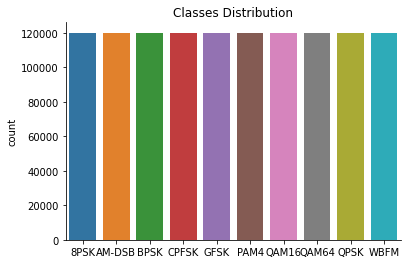

In [ ]:
plt.title("Classes Distribution")
sns.countplot(x = labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

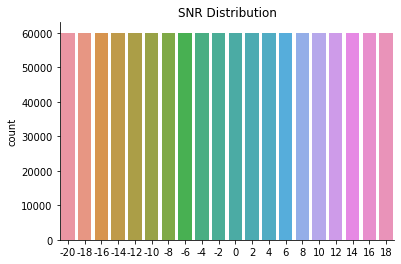

In [ ]:
plt.title("SNR Distribution")
sns.countplot(x = labels[:,1])
sns.despine(top = True, right = True, left = False, bottom = False)

# each class has 6k samples from the same SNR

In [ ]:
def visualize(mod,snr):
  plt.figure(1)
  plt.title(mod + " SNR = " + str(snr))
  plt.plot(data[(mod,snr)][0][0])
  plt.plot(data[(mod,snr)][0][1])
  plt.show()

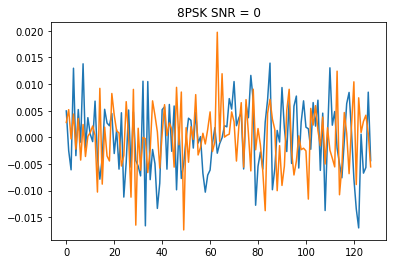

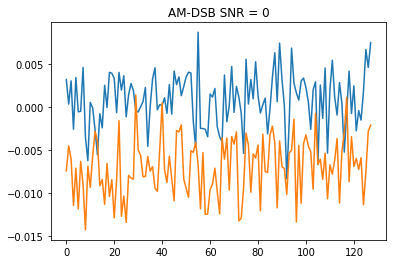

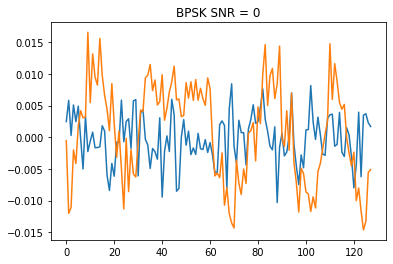

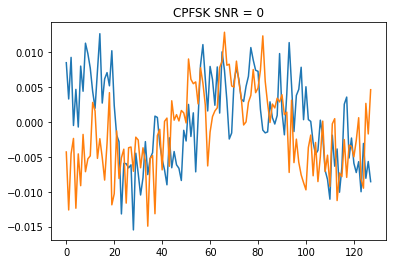

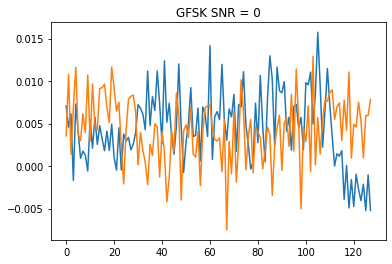

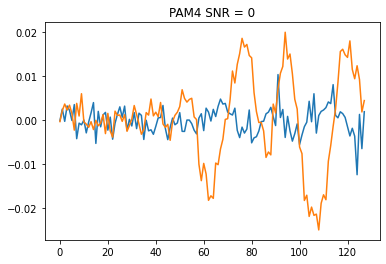

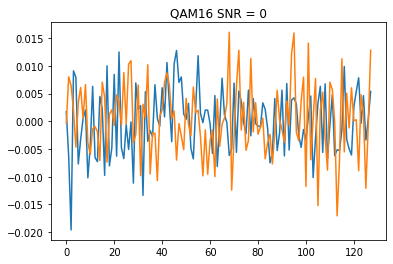

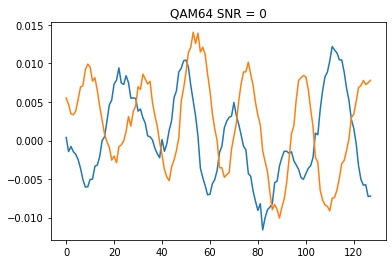

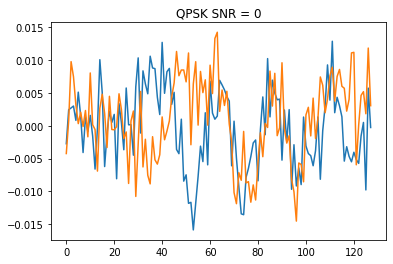

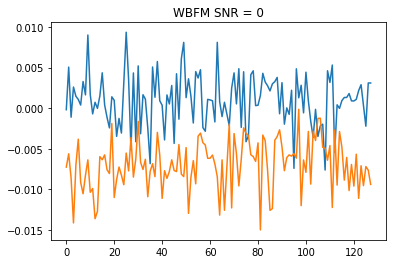

In [ ]:
# ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
visualize("8PSK",0)
visualize("AM-DSB",0)
visualize("BPSK",0)
visualize("CPFSK",0)
visualize("GFSK",0)
visualize("PAM4",0)
visualize("QAM16",0)
visualize("QAM64",0)
visualize("QPSK",0)
visualize("WBFM",0)

In [ ]:
combined_dataset = np.empty((dataset.shape[0],dataset.shape[1],3*dataset.shape[2]),dtype=np.float32)
for i in range(dataset.shape[0]):
  combined_dataset[i] = np.array([np.append(dataset[i][0],np.append(np.gradient(dataset[i][0]),integrate.cumtrapz(dataset[i][0],initial=0))),np.append(dataset[i][0],np.append(np.gradient(dataset[i][1]),integrate.cumtrapz(dataset[i][1],initial=0)))])

# for memory efficiency 
del dataset
del data

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(dataset,labels[:,0].astype(int), test_size=0.3, 
                                                                            random_state=42,stratify=labels)


In [ ]:
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.05, 
                                                                          random_state=42,stratify=train_labels)

In [ ]:
del dataset
del data

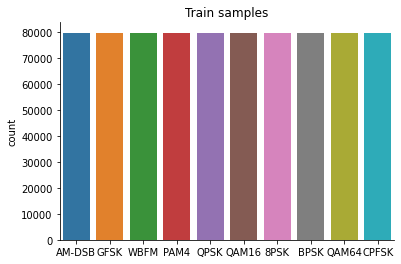

In [ ]:
plt.title("Train samples")
sns.countplot(x = train_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

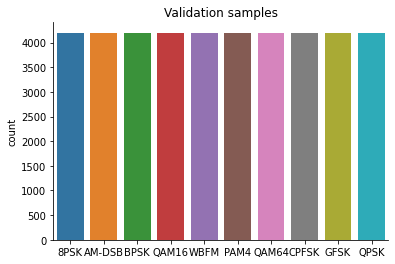

In [ ]:
plt.title("Validation samples")
sns.countplot(x = val_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

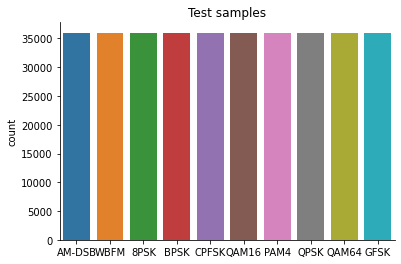

In [ ]:
plt.title("Test samples")
sns.countplot(x = test_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

In [ ]:
class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.feat_arr[index]).float(),torch.tensor((self.label[index]))
    #TODO
  def __len__(self):
    return len(self.feat_arr)

In [ ]:
BATCH_SIZE = 4
train_dataset = dataset(train_features.reshape((-1,2,1,128)),train_labels)

# TODO what is num_worker do
train_dataloader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
val_dataset = dataset(val_features.reshape((-1,2,1,128)),val_labels)

# TODO what is num_worker do
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
del train_features
del train_labels
del val_features
del val_labels

In [ ]:
del val_dataset
del train_dataset

In [ ]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([4, 2, 1, 128])
torch.Size([4])


In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=(1,3),stride=1)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1,2),stride=1)

        self.fc1 = nn.Linear(in_features=2000,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=11)


    # Defining the forward pass    
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = torch.flatten(x,1)
      x = F.relu(self.fc1(x))
      x = F.log_softmax(self.fc2(x),dim=0)
      return x

net = Net()

In [ ]:
from tqdm import tqdm
from collections import defaultdict
def train_model(model, train_dataloader, val_dataloader, extra):
    
    
    if extra == 0:
      epochs = 30
    else:
      epochs = 5
    # to store the results
    summary = defaultdict(list)
    # to select GPU for running
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(device)

    # identifying the loss and optimizer funtions for weights calculations
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.0003)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

    # to apply the gpu for the model and loss functions
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for inputs, labels in tqdm(train_dataloader):

                optimizer.zero_grad()
                train_labels = labels.to(device)
                train_inputs = inputs.to(device)

                output = model(train_inputs)
                
                batch_loss = criterion(output, train_labels)
                total_loss_train += float(batch_loss.item())
                
                acc = (output.argmax(dim=1) == train_labels).sum().item()
                total_acc_train += float(acc)
                del acc


                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            # scheduler.step()
            total_acc_val = 0
            total_loss_val = 0

            # Disabling gradient calculation is useful for inference to avoid dependency
            with torch.no_grad():

                # repreat for the previous but for the validation set 
                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += float(batch_loss.item())
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += float(acc)
                    del acc
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_features): .3f} | Train Accuracy: {total_acc_train / len(train_features): .3f} | Val Loss: {total_loss_val / len(val_features): .3f} | Val Accuracy: {total_acc_val / len(val_features): .3f}')
            summary['train_acc'].append(total_acc_train/len(train_features))
            summary['train_loss'].append(total_loss_train/len(train_features))
            summary['val_acc'].append(total_acc_val/len(val_features))
            summary['val_loss'].append(total_loss_val/len(val_features))

    return model,summary

In [ ]:
model, summary = train_model(net, train_dataloader, val_dataloader, 0)

cuda


100%|██████████| 199500/199500 [08:37<00:00, 385.33it/s]


Epochs: 1 | Train Loss:  0.508 | Train Accuracy:  0.180 | Val Loss:  0.475 | Val Accuracy:  0.233


100%|██████████| 199500/199500 [08:19<00:00, 399.01it/s]


Epochs: 2 | Train Loss:  0.469 | Train Accuracy:  0.242 | Val Loss:  0.465 | Val Accuracy:  0.252


100%|██████████| 199500/199500 [08:14<00:00, 403.17it/s]


Epochs: 3 | Train Loss:  0.463 | Train Accuracy:  0.252 | Val Loss:  0.462 | Val Accuracy:  0.246


100%|██████████| 199500/199500 [08:12<00:00, 404.97it/s]


Epochs: 4 | Train Loss:  0.461 | Train Accuracy:  0.255 | Val Loss:  0.465 | Val Accuracy:  0.248


100%|██████████| 199500/199500 [08:10<00:00, 406.42it/s]


Epochs: 5 | Train Loss:  0.460 | Train Accuracy:  0.255 | Val Loss:  0.459 | Val Accuracy:  0.261


100%|██████████| 199500/199500 [08:30<00:00, 390.55it/s]


Epochs: 6 | Train Loss:  0.459 | Train Accuracy:  0.259 | Val Loss:  0.457 | Val Accuracy:  0.264


100%|██████████| 199500/199500 [08:26<00:00, 394.02it/s]


Epochs: 7 | Train Loss:  0.456 | Train Accuracy:  0.263 | Val Loss:  0.454 | Val Accuracy:  0.267


100%|██████████| 199500/199500 [08:10<00:00, 406.90it/s]


Epochs: 8 | Train Loss:  0.454 | Train Accuracy:  0.265 | Val Loss:  0.458 | Val Accuracy:  0.269


100%|██████████| 199500/199500 [08:10<00:00, 406.56it/s]


Epochs: 9 | Train Loss:  0.452 | Train Accuracy:  0.266 | Val Loss:  0.450 | Val Accuracy:  0.267


100%|██████████| 199500/199500 [08:19<00:00, 399.27it/s]


Epochs: 10 | Train Loss:  0.449 | Train Accuracy:  0.270 | Val Loss:  0.447 | Val Accuracy:  0.283


100%|██████████| 199500/199500 [08:08<00:00, 408.51it/s]


Epochs: 11 | Train Loss:  0.436 | Train Accuracy:  0.291 | Val Loss:  0.411 | Val Accuracy:  0.321


100%|██████████| 199500/199500 [08:07<00:00, 409.03it/s]


Epochs: 12 | Train Loss:  0.394 | Train Accuracy:  0.346 | Val Loss:  0.380 | Val Accuracy:  0.365


100%|██████████| 199500/199500 [08:08<00:00, 408.22it/s]


Epochs: 13 | Train Loss:  0.374 | Train Accuracy:  0.377 | Val Loss:  0.368 | Val Accuracy:  0.386


100%|██████████| 199500/199500 [08:12<00:00, 405.45it/s]


Epochs: 14 | Train Loss:  0.359 | Train Accuracy:  0.403 | Val Loss:  0.353 | Val Accuracy:  0.408


100%|██████████| 199500/199500 [08:14<00:00, 403.80it/s]


Epochs: 15 | Train Loss:  0.347 | Train Accuracy:  0.425 | Val Loss:  0.341 | Val Accuracy:  0.427


100%|██████████| 199500/199500 [08:12<00:00, 405.38it/s]


Epochs: 16 | Train Loss:  0.339 | Train Accuracy:  0.438 | Val Loss:  0.338 | Val Accuracy:  0.442


100%|██████████| 199500/199500 [08:14<00:00, 403.44it/s]


Epochs: 17 | Train Loss:  0.334 | Train Accuracy:  0.445 | Val Loss:  0.332 | Val Accuracy:  0.451


100%|██████████| 199500/199500 [08:29<00:00, 391.57it/s]


Epochs: 18 | Train Loss:  0.330 | Train Accuracy:  0.452 | Val Loss:  0.331 | Val Accuracy:  0.454


100%|██████████| 199500/199500 [08:20<00:00, 398.90it/s]


Epochs: 19 | Train Loss:  0.328 | Train Accuracy:  0.455 | Val Loss:  0.330 | Val Accuracy:  0.449


100%|██████████| 199500/199500 [08:18<00:00, 400.34it/s]


Epochs: 20 | Train Loss:  0.327 | Train Accuracy:  0.456 | Val Loss:  0.325 | Val Accuracy:  0.459


100%|██████████| 199500/199500 [08:17<00:00, 400.98it/s]


Epochs: 21 | Train Loss:  0.326 | Train Accuracy:  0.458 | Val Loss:  0.331 | Val Accuracy:  0.453


100%|██████████| 199500/199500 [08:16<00:00, 401.46it/s]


Epochs: 22 | Train Loss:  0.324 | Train Accuracy:  0.460 | Val Loss:  0.324 | Val Accuracy:  0.463


100%|██████████| 199500/199500 [08:17<00:00, 401.04it/s]


Epochs: 23 | Train Loss:  0.324 | Train Accuracy:  0.461 | Val Loss:  0.322 | Val Accuracy:  0.465


100%|██████████| 199500/199500 [08:19<00:00, 399.69it/s]


Epochs: 24 | Train Loss:  0.323 | Train Accuracy:  0.463 | Val Loss:  0.325 | Val Accuracy:  0.456


100%|██████████| 199500/199500 [08:21<00:00, 397.46it/s]


Epochs: 25 | Train Loss:  0.322 | Train Accuracy:  0.464 | Val Loss:  0.324 | Val Accuracy:  0.463


100%|██████████| 199500/199500 [08:21<00:00, 397.48it/s]


Epochs: 26 | Train Loss:  0.321 | Train Accuracy:  0.465 | Val Loss:  0.323 | Val Accuracy:  0.468


100%|██████████| 199500/199500 [08:27<00:00, 392.89it/s]


Epochs: 27 | Train Loss:  0.321 | Train Accuracy:  0.466 | Val Loss:  0.320 | Val Accuracy:  0.465


100%|██████████| 199500/199500 [08:36<00:00, 386.50it/s]


Epochs: 28 | Train Loss:  0.321 | Train Accuracy:  0.467 | Val Loss:  0.323 | Val Accuracy:  0.468


100%|██████████| 199500/199500 [08:17<00:00, 400.69it/s]


Epochs: 29 | Train Loss:  0.321 | Train Accuracy:  0.467 | Val Loss:  0.321 | Val Accuracy:  0.466


100%|██████████| 199500/199500 [08:15<00:00, 402.27it/s]


Epochs: 30 | Train Loss:  0.321 | Train Accuracy:  0.468 | Val Loss:  0.326 | Val Accuracy:  0.461


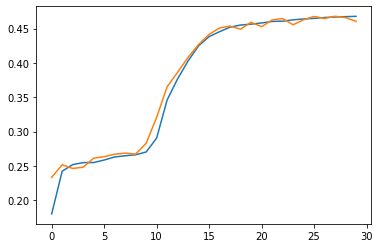

In [ ]:
plt.plot(summary['train_acc'])
plt.plot(summary['val_acc'])

In [ ]:
model, summary2 = train_model(model, train_dataloader, val_dataloader, 1)

cuda


100%|██████████| 199500/199500 [08:20<00:00, 399.00it/s]


Epochs: 1 | Train Loss:  0.320 | Train Accuracy:  0.469 | Val Loss:  0.323 | Val Accuracy:  0.467


100%|██████████| 199500/199500 [08:30<00:00, 390.42it/s]


Epochs: 2 | Train Loss:  0.320 | Train Accuracy:  0.469 | Val Loss:  0.322 | Val Accuracy:  0.464


100%|██████████| 199500/199500 [08:29<00:00, 391.62it/s]


Epochs: 3 | Train Loss:  0.320 | Train Accuracy:  0.469 | Val Loss:  0.321 | Val Accuracy:  0.459


100%|██████████| 199500/199500 [08:26<00:00, 393.85it/s]


Epochs: 4 | Train Loss:  0.320 | Train Accuracy:  0.469 | Val Loss:  0.320 | Val Accuracy:  0.470


100%|██████████| 199500/199500 [08:18<00:00, 399.99it/s]


Epochs: 5 | Train Loss:  0.319 | Train Accuracy:  0.470 | Val Loss:  0.322 | Val Accuracy:  0.468


In [ ]:
model, summary3 = train_model(model, train_dataloader, val_dataloader, 1)

cuda


100%|██████████| 199500/199500 [08:15<00:00, 402.63it/s]


Epochs: 1 | Train Loss:  0.320 | Train Accuracy:  0.471 | Val Loss:  0.323 | Val Accuracy:  0.464


100%|██████████| 199500/199500 [08:10<00:00, 407.06it/s]


Epochs: 2 | Train Loss:  0.319 | Train Accuracy:  0.471 | Val Loss:  0.323 | Val Accuracy:  0.461


100%|██████████| 199500/199500 [08:08<00:00, 408.42it/s]


Epochs: 3 | Train Loss:  0.319 | Train Accuracy:  0.472 | Val Loss:  0.323 | Val Accuracy:  0.462


100%|██████████| 199500/199500 [08:08<00:00, 408.29it/s]


Epochs: 4 | Train Loss:  0.319 | Train Accuracy:  0.472 | Val Loss:  0.322 | Val Accuracy:  0.463


100%|██████████| 199500/199500 [08:44<00:00, 380.13it/s]


Epochs: 5 | Train Loss:  0.319 | Train Accuracy:  0.472 | Val Loss:  0.320 | Val Accuracy:  0.469


In [ ]:
def test_model(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    y_pred=[]
    y_true=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    model.eval()
    # Disabling gradient calculation is useful for inference to avoid dependency
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_input = test_input.to(device)
              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              
              y_pred.extend((torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()) # Save Prediction
      
              test_label = test_label.data.cpu().numpy()
              y_true.extend(test_label) # Save Truth

            
    print(f'Test Accuracy: {total_acc_test / len(test_features): .3f}')
    return y_pred, y_true, total_acc_test / len(test_features)

In [ ]:
test_dataset = dataset(test_features.reshape((-1,2,1,128)),test_labels)

In [ ]:
test_dataloader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
y_pred,y_true,total_acc = test_model(model,test_dataloader)

Test Accuracy:  0.467


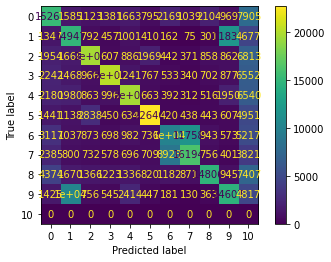

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()